In [4]:
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import numpy as np
import cv2

In [2]:
root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
metadata

{'candle_distances': {'left_middle': 415, 'middle_right': 380},
 'photos': {'flir_20191112T174218.jpg': {'distance': 1150, 'adjusted': False},
  'flir_20191112T174252.jpg': {'distance': 1950, 'adjusted': False},
  'flir_20191112T174307.jpg': {'distance': 3150, 'adjusted': False},
  'flir_20191112T174330.jpg': {'distance': 3150, 'adjusted': False},
  'flir_20191112T174344.jpg': {'distance': 3800, 'adjusted': False},
  'flir_20191112T174427.jpg': {'distance': 1950, 'adjusted': True},
  'flir_20191112T174545.jpg': {'distance': 1950, 'adjusted': True}}}

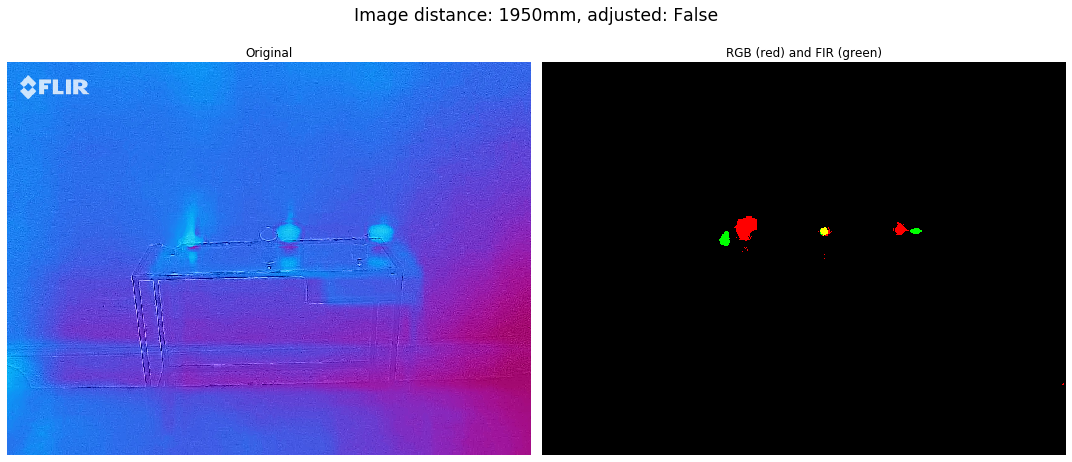

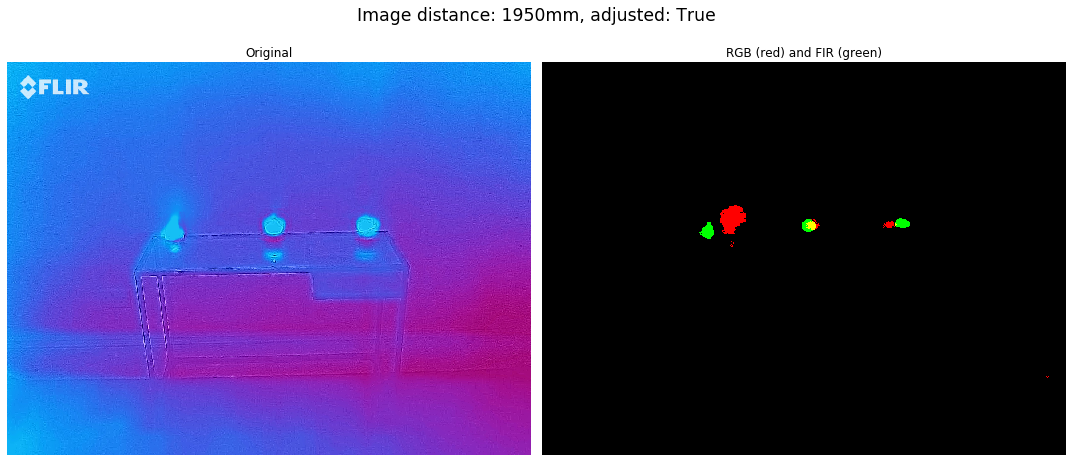

In [9]:
def load_images(name):
    original = cv2.imread(os.path.join(root_path, name)) / 255
    thermal = cv2.imread(os.path.join(root_path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(root_path, "extracted/visible", name)) / 255
    return original, thermal, visible

def display_images(name, metadata):
    orig, thr, vis = load_images(name)

    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))

    # Threshold
    vis = np.where(vis > 0.91, 1, 0)
    thr = np.where(thr > 0.15, 1, 0)

    # Superimpose as red and green channel and plot
    sup = np.dstack([vis, thr, np.zeros(thr.shape)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(orig)
    ax1.set_title("Original")
    ax1.axis("off")
    ax2.imshow(sup)
    ax2.set_title("RGB (red) and FIR (green)")
    ax2.axis("off")
    
    distance = metadata["photos"][name]["distance"]
    adjusted = metadata["photos"][name]["adjusted"]
    fig.suptitle(f"Image distance: {distance}mm, adjusted: {adjusted}", y=0.85, size="xx-large")
    plt.tight_layout()


display_images(list(metadata["photos"].keys())[1], metadata)
display_images(list(metadata["photos"].keys())[6], metadata)